<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp2/blob/main/notebooks/analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####  Referencias

* [Pandas pipelines](https://calmcode.io/pandas-pipe/end.html)
* [Python logger](https://www.youtube.com/watch?v=g8nQ90Hk328&list=PLi01XoE8jYohWFPpC17Z-wWhPOSuh8Er-&index=17)
* [Dataset](https://smallworldofwords.org/en/project/research)
* [Glove word embedding](https://nlp.stanford.edu/projects/glove/)
* [Elmo word embedding](https://allennlp.org/elmo)
* [Basics of Using Pre-trained GloVe Vectors in Python](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)

####  Ejemplos

* [Ejemplo word2vect](https://colab.research.google.com/drive/1YcplHjDL1M6G9K62W4GyUbic0OxOt8GZ?usp=sharing)
* [Ejemplo carga de dataset](https://colab.research.google.com/drive/1Qlq56GM6xERVpy6FAJhS5XCqaAKGlGtD?usp=sharing)
* [Análisis de Redes 1](https://colab.research.google.com/drive/1ef-fnqmPsAxqlIc_ZrBXa0Fg6IYYf_g_?usp=sharing)
* [Análisis de Redes 2](https://colab.research.google.com/drive/1IaIreaEvIXiOq0gmjYJw7Q1y9lhY20ZM?usp=sharing#scrollTo=4v-e0C44llje)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

### 1. Instalacion de paquetes

In [3]:
if is_runing_into_colab_env(): 
    !pip install rich
    !pip install networkx
    !pip install gensim

###  2. Importa libreria del proyecto

In [4]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp2'):
        print('Pull...\n')
        !cd dm-cyt-tp2; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp2.git

In [5]:
sys.path.append('/content/dm-cyt-tp2/src' if is_runing_into_colab_env() else '../src')
dataset_path = '/content/dm-cyt-tp2/datasets/{}' if is_runing_into_colab_env() else '../datasets/{}'

###  3. Importa paquetes externos

In [6]:
%load_ext rich

In [35]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd
import networkx as nx
import logging

from logger import setup_logger

from step   import rename_columns, \
                   plot_frequency, \
                   select

from graph  import graph_summary, \
                   graph_edges, \
                   plot_edge_weight_hist, \
                   plot_clustering_coeficient_hist, \
                   plot_nodes_degree_hist, \
                   plot_cumulative_nodes_degree_hist_comparative, \
                   plot_centrality_mesures_heatmap, \
                   graph_subsampling, \
                   plot_modularity_coeficient, \
                   graph_modularity, \
                   subgraph_without_isolated_nodes, \
                   isolated_nodes

from embedding import GoogleW2VSimilarity

from dataset import summary

In [8]:
setup_logger(format = '%(levelname)s: %(message)s')

### 4. Cargar dataset

(367188, 5)


,source,response,sww_weight,w2v_google_weight,w2v_glove_weight
0,although,nevertheless,0.033333,0.604110,NaN
1,although,though,0.033333,0.784028,NaN
2,although,question,0.033333,0.091440,NaN
3,although,however,0.033333,0.614937,NaN
4,although,even,0.033333,0.522209,NaN


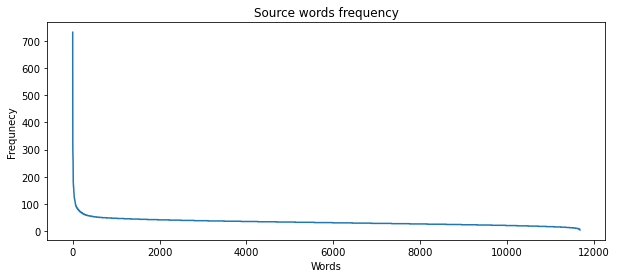

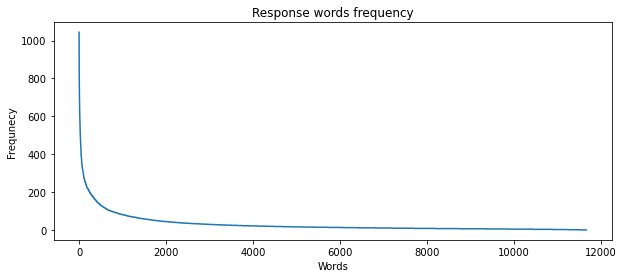

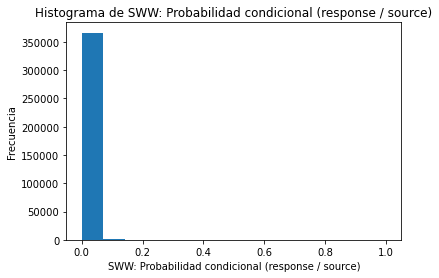

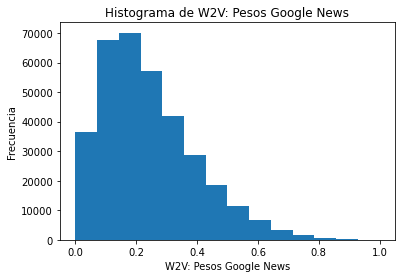

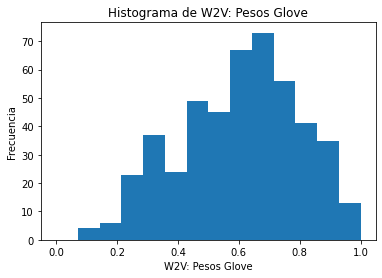

In [9]:
dataset = pd.read_csv(dataset_path.format('processed_dataset.csv'))
summary(dataset)

### 5. Tareas

#### 5.1. Construcción de los grafos

A continacion tomamos por un lado **dataset** (el cual tiene las columnas pregunta y respuesta) y por el otro el diccionario de **word_embeddings** y finalmente convertimos ambos datasets en grafos.

Creamos un dataset pesado por la distancia coseno entre las palabras fitlradas desde **Small World of Words**:

In [10]:
graph_subsampling_percent = 0.1

# W2V:
w2v_weight_type  = 'google' # 'glove'
w2v_min_distance = 0.1

# SWW:
sww_min_distance = 0.1

In [11]:
w2v_weight_column = 'w2v_{}_weight'.format(w2v_weight_type)
w2v_weight_column

'w2v_google_weight'

**Grafo SWW**

Creamos el grafo con los pesos corresspondiende a la probabilidad condicional **P(response / source)**:

INFO: (367188, 5) --> rename_columns({}) --> (367188, 5)
INFO: (367188, 5) --> select({}) --> (367188, 3)


,source,response,weight
0,although,nevertheless,0.033333
1,although,though,0.033333
2,although,question,0.033333
3,although,however,0.033333
4,although,even,0.033333


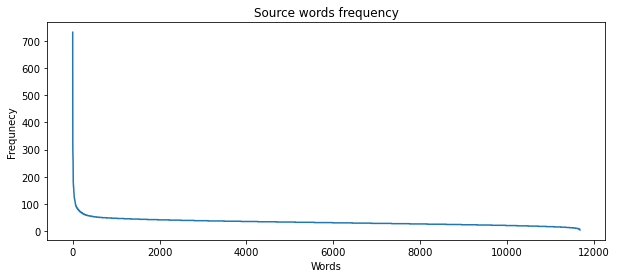

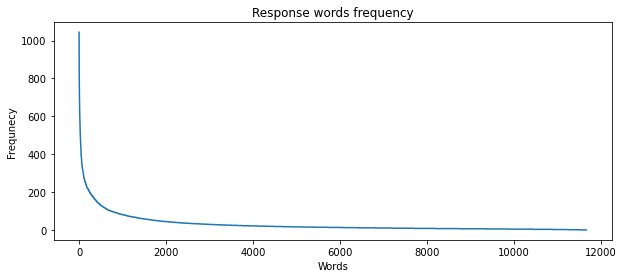

In [12]:
sww_graph_dataset = dataset[
        dataset.sww_weight.notnull() &
        dataset.sww_weight > sww_min_distance
    ] \
    .pipe(rename_columns, { 'sww_weight': 'weight' }) \
    .pipe(select, ['source', 'response', 'weight']) \
    .pipe(plot_frequency, column = 'source') \
    .pipe(plot_frequency, column = 'response')

sww_graph_dataset.head()

In [13]:
sww_graph = nx.from_pandas_edgelist(
    sww_graph_dataset, 
    'source',  
    'response',
    'weight',
    create_using=nx.DiGraph()
)

sww_graph = graph_subsampling(sww_graph, percent = graph_subsampling_percent)

# isolated_nodes(sww_graph)

In [14]:
sww_graph = subgraph_without_isolated_nodes(sww_graph)

isolated_nodes(sww_graph)

set()

DiGraph with 1161 nodes and 3621 edges
Es pesado?  Si
Es dirigido?  Si
Tiene ciclos?  Si
Tiene multiples aristas?  No


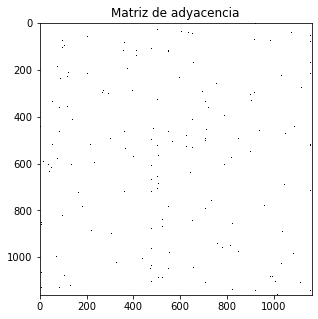

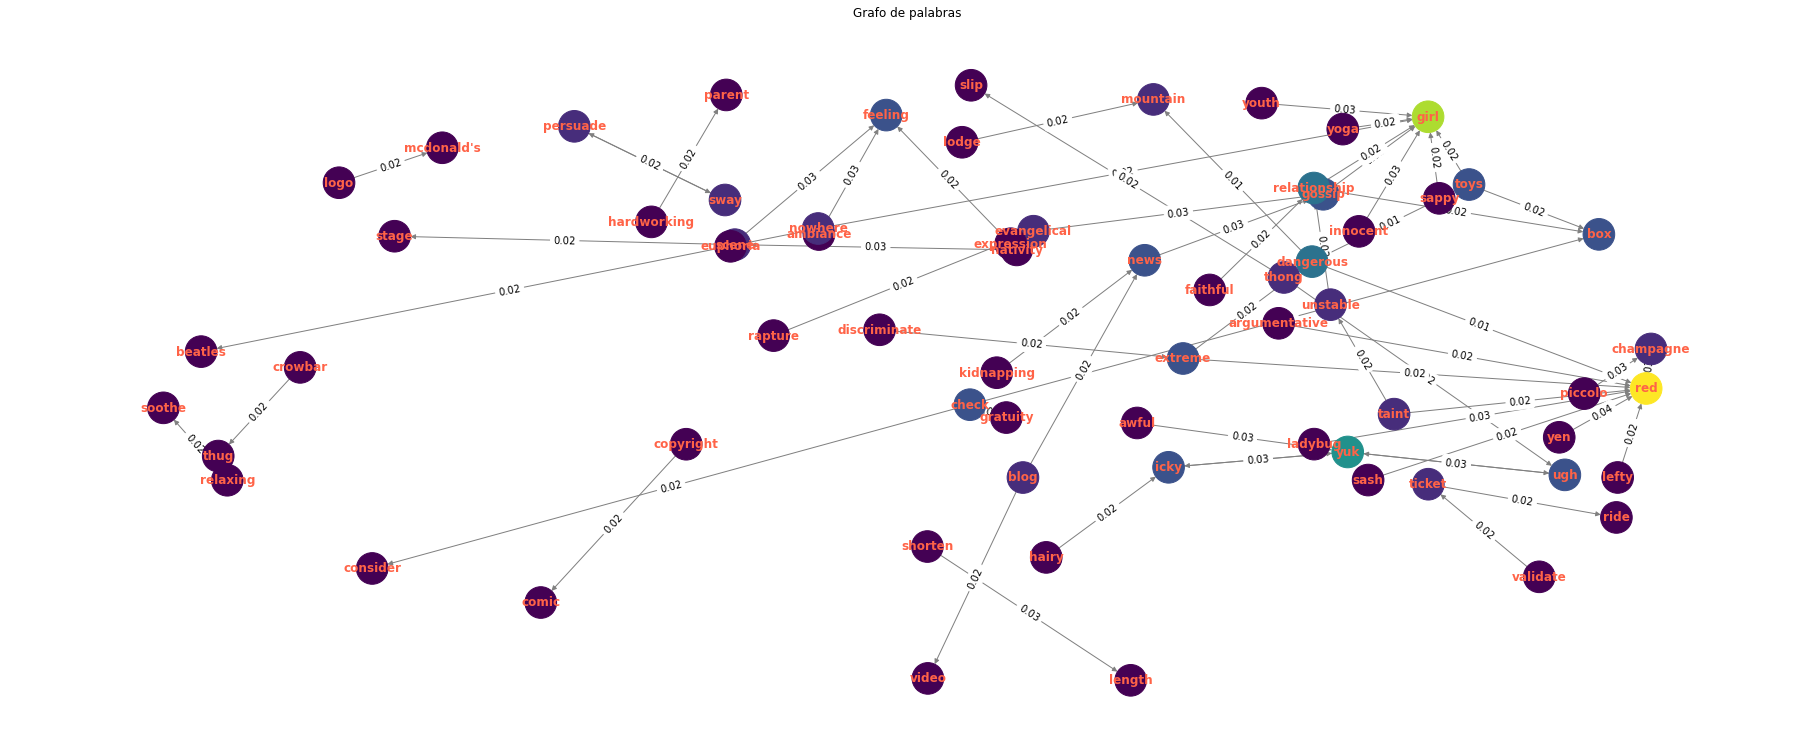

In [62]:
graph_summary(sww_graph, k_percent=0.13, k_layout=0.1)

**Grafo W2V**

Creamos el grafo Gw2v con los pesos selecionado de la columna **w2v_weight_column** (Ver setting mas arriba):

INFO: (350243, 5) --> rename_columns({}) --> (350243, 5)
INFO: (350243, 5) --> select({}) --> (350243, 3)


,source,response,weight
0,although,nevertheless,0.604110
1,although,though,0.784028
2,although,question,0.091440
3,although,however,0.614937
4,although,even,0.522209


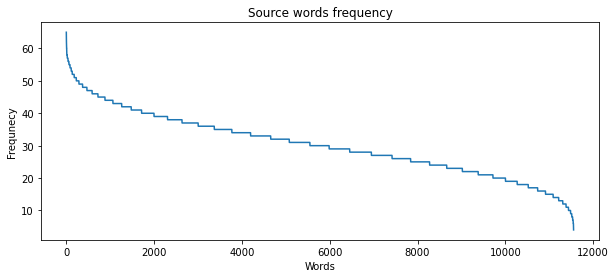

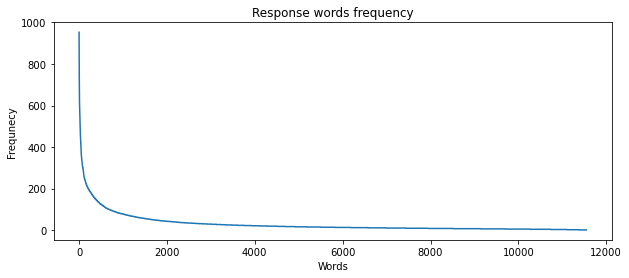

In [63]:
w2v_graph_dataset = dataset[
        dataset[w2v_weight_column].notnull() &
        dataset[w2v_weight_column] > w2v_min_distance
    ] \
    .pipe(rename_columns, { w2v_weight_column: 'weight' }) \
    .pipe(select, ['source', 'response', 'weight']) \
    .pipe(plot_frequency, column = 'source') \
    .pipe(plot_frequency, column = 'response')

w2v_graph_dataset.head()

Creamos un grafo pesado:

In [64]:
w2v_graph = nx.from_pandas_edgelist(
    w2v_graph_dataset, 
    'source',  
    'response',
    'weight'
)

**Importante**: Nos quedamos con solo con los nodos que tambien existen en **Gsww**:

In [65]:
w2v_graph = w2v_graph.subgraph(list(sww_graph.nodes))

In [66]:
w2v_graph = subgraph_without_isolated_nodes(w2v_graph)

Graph with 1112 nodes and 3101 edges
Es pesado?  Si
Es dirigido?  No
Tiene ciclos?  Si
Tiene multiples aristas?  No


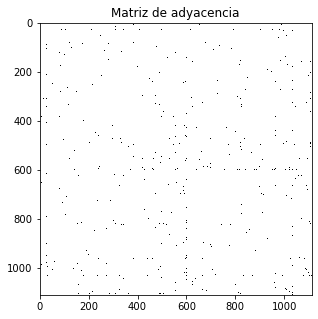

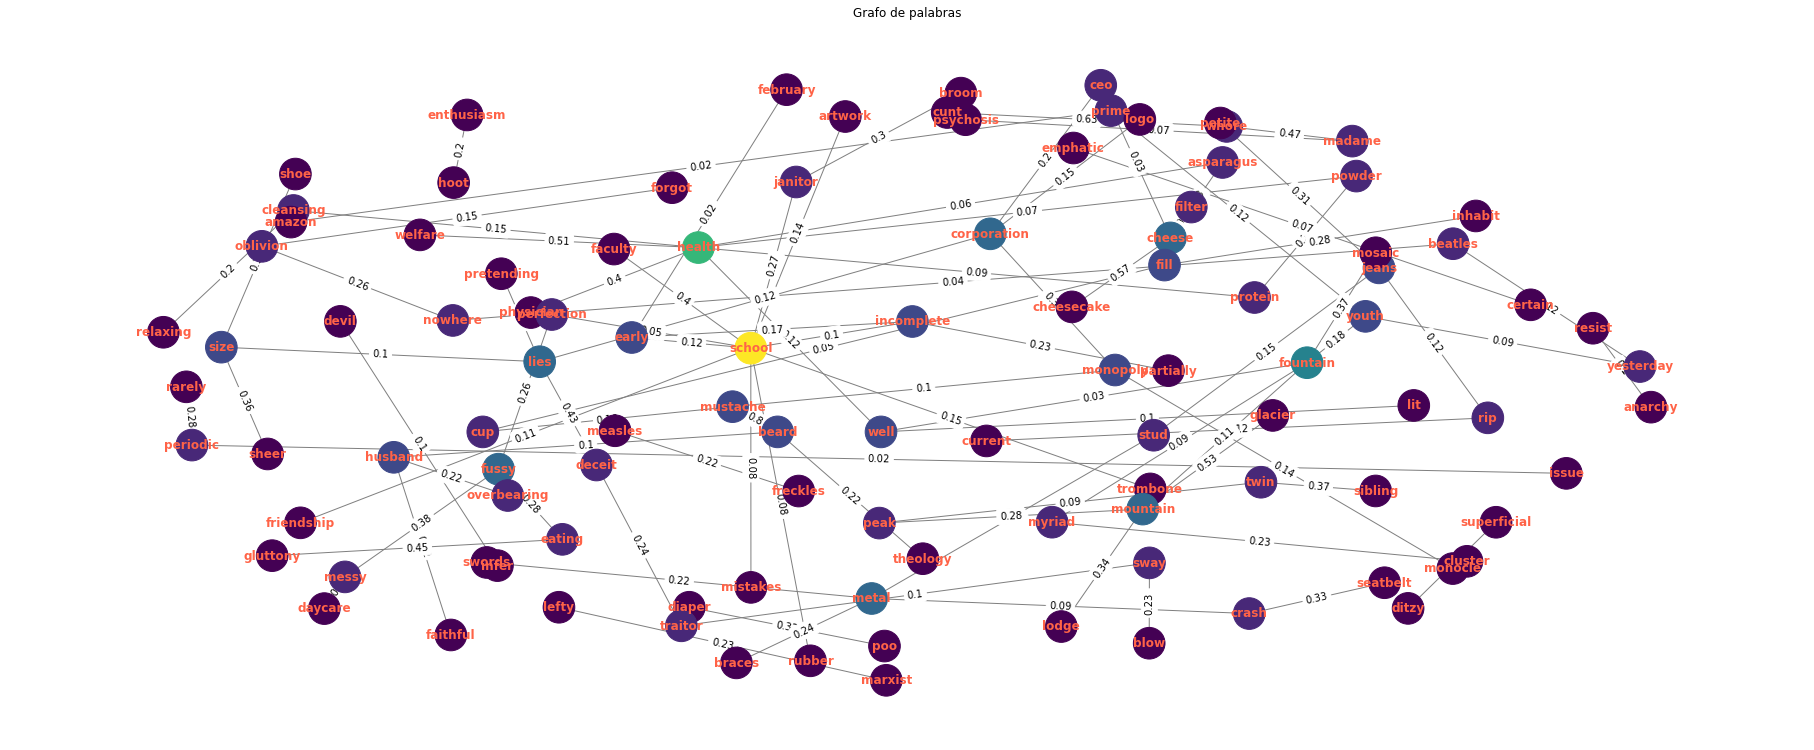

In [67]:
graph_summary(w2v_graph, k_percent=0.18, k_layout=0.3)

#### 5.2. Carácterización de los grafos

Comparar los dos grafos en terminos de medidas de cliques/clustering, distintas medidas de centralidad3, distribución de pesos, distribución de grado, asortatividad, camino mínimo, diámetro, etc. ¿Qué pueden decir de cada uno de los grafos? ¿Y qué pueden decir de la comparación entre ellos?

**Opcional 1**: ¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado?

**Distribución de pesos**

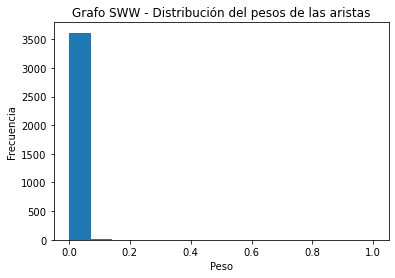

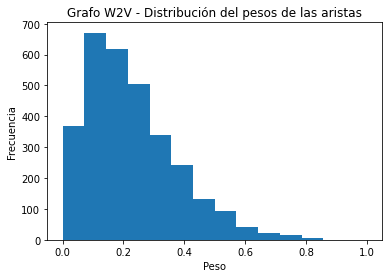

In [21]:
plot_edge_weight_hist(sww_graph, title='Grafo SWW')
plot_edge_weight_hist(w2v_graph, title='Grafo W2V')

**Distribución de grado**

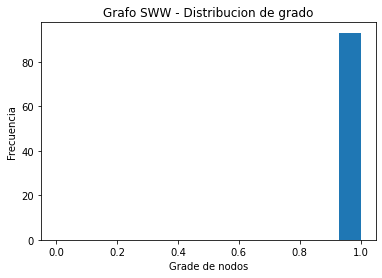

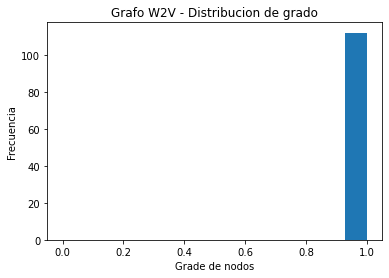

In [22]:
plot_nodes_degree_hist(sww_graph, title='Grafo SWW')
plot_nodes_degree_hist(w2v_graph, title='Grafo W2V')

**Coeficiente de clustering de grado**

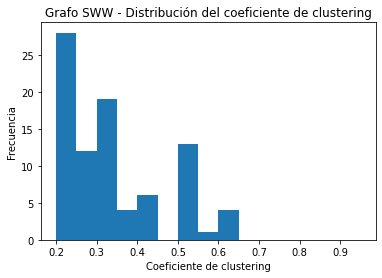

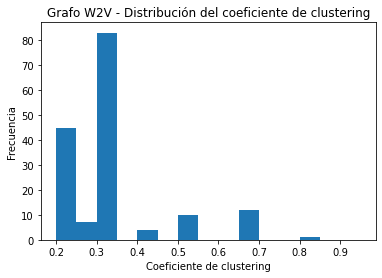

In [23]:
plot_clustering_coeficient_hist(sww_graph, title='Grafo SWW')
plot_clustering_coeficient_hist(w2v_graph, title='Grafo W2V')

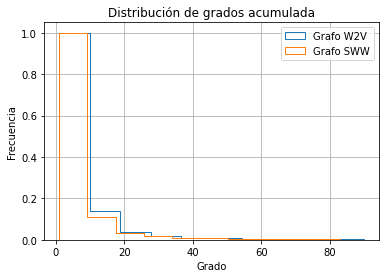

In [24]:
plot_cumulative_nodes_degree_hist_comparative(sww_graph, w2v_graph, 'Grafo W2V', 'Grafo SWW')

Estan solapadasm, lo cual tiene sentido ya que los dos grafos tiene las misma conexiones.

**Medidas de centralidad**

Grafica r sub grafos para:

* Centralidado de Grado
* Centralidado de Intermediación (betweenness)
* Centralidado de Cercanía (Closeness)
* Centralidado de Centralidad de autovectores (Eigenvector centrality)

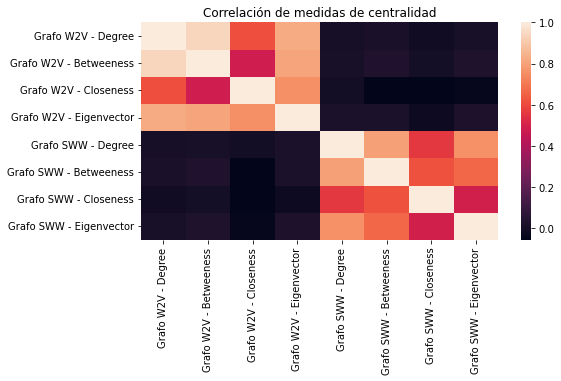

In [25]:
plot_centrality_mesures_heatmap(w2v_graph, sww_graph, 'Grafo W2V', 'Grafo SWW')

#### 5.3. Comunidades

Detectar comunidades en Gsww y Gw2v con el algoritmo que consideren más indicado, justificar por qué. Calcular el indice de modularidad en cada caso ¿Qué pueden decir de las comunidades?
Comparar las comunidades de ambas redes con el índice rand (u otra métrica que considere adecuada) ¿Son similares?
Visualizar uno de los grafos, y pintarlo según las comunidades del otro ¿Qué se puede decir?
También se puede analizar la resolución del algoritmo de por el cuál se detectan las comunidades. Para ello, pueden explorar estructuras dentro de alguna de las comunidades.

* **Opcional 2**: Utilizar distintos algoritmos y comparar los resultados.
* **Opcional 3**: ¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado? ¿Y para Gw2v?
* **Opcional 4**: Utilizar algoritmos de reducción de dimensionalidad como MDS, tSNE, o UMAP para ubicar las palabras en dos dimensiones y pintar según las comunidades identificadas. Se puede elegir un subconjunto de palabras para que sea más claro. También pueden proyectar en el espacio construido con word2vec y pintar según las comunidades identificadas en Gsww, o viceversa.

In [26]:
# graph_modularity(sww_graph)
# graph_modularity(w2v_graph)

COMPLETAR

#### 5.4. Small-world y redes prototípicas

Existen trabajos previos que muestran que tanto la red de asociaciones (Gsww) como la red semántica (Gw2v) tienen estructura de small-world [5, 6]. Comparar las características de redes, como el camino mínimo, con distintos modelos de redes, en particular con redes small-world. Para ello generar N redes small-world con el mismo número de nodos y aristas, y evaluar si las características medidas en Gsww y Gw2v podrían pertenecer a dichas distribuciones.

* **Opcional 4**: Además de realizar esta tarea con el small-world, repetirlo con las random o scale-free.

COMPLETAR